# Hole module 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import MDAnalysis as mda
import MDAnalysis.analysis.hole

In [2]:
mda.start_logging()

MDAnalysis  : INFO     MDAnalysis 0.17.1-dev STARTED logging to 'MDAnalysis.log'


I am testing HOLE on a simple "trajectory": I submitted gramicidin A (1grm, test file `1gmr_single.pdb`) to the [ElNemo](http://www.sciences.univ-nantes.fr/elnemo/) elastic network server. From an ENM it computed a number of modes and provided multi-frame PDB files showing these modes. I just picked the first mode (which is labelled mode 7), which shows a twist motion along the pore axis. Note that this "trajectory" is exaggerated and does not correspond to real protein motion.

The trajectory can be downloaded from https://www.dropbox.com/sh/c2d6i24oz00idqp/AACjPT_T1fnfo-qNB_ksFKEta?dl=0.

u = mda.Universe("./1grm_elNemo_mode7.pdb.bz2")

In the latest version of MDAnalysis (development or 0.16.0 when it comes out), this trajectory is included:

In [3]:
from MDAnalysis.tests.datafiles import MULTIPDB_HOLE
u = mda.Universe(MULTIPDB_HOLE)

/Volumes/Data/oliver/Biop/Projects/Methods/MDAnalysis/mdanalysis/testsuite/MDAnalysisTests/__init__.py:109: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/oliver/anaconda3/envs/mda_develop/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/oliver/anaconda3/envs/mda_develop/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/oliver/anaconda3/envs/mda_develop/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/oliver/anaconda3/envs/mda_develop/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


## Running HOLE
You need to install `HOLE` first, which is available from http://www.holeprogram.org/ under the Apache open source license.

Set up the `HOLEtraj` class; provide a path to the `hole` executable.

In [4]:
H = MDAnalysis.analysis.hole.HOLEtraj(u, executable="~/hole2/exe/hole")

Then run `hole` on the individual frames (this takes a while...)

In [5]:
H.run()

MDAnalysis.analysis.hole: INFO     HOLE analysis frame    0 (orderparameter 0)
MDAnalysis.analysis.hole: INFO     Setting up HOLE analysis for '/var/folders/ds/z7mbf7nx1gn31308g31t9tcc0000gp/T/tmpnkei5a_a.pdb'
MDAnalysis.analysis.hole: INFO     Using radius file 'simple2.rad'
MDAnalysis.analysis.hole: CRITICAL HOLE binary '~/hole2/exe/hole' not found.
MDAnalysis.analysis.hole: CRITICAL '~/hole2/exe/hole' must be on the PATH or provided as keyword argument 'executable'.


FileNotFoundError: [Errno 2] HOLE binary '~/hole2/exe/hole' not found.

The trajectory contains 11 frames. We are typically interested in the *HOLE profile*, i.e., a plot of the pore radius as determined by HOLE against the reaction coordinate (often close to $z$ along the pore axis for simple channels).

All profiles are stored as
```python
H.profiles
```
which is a `dict`. The keys are the frame numbers (or a user supplied reaction coordinate for the conformation). The values are record arrays with columns `frame` (the reaction coordinate for the conformation), `rxncoord` (the HOLE pore reaction coordinate), and `radius` (radius in Angstrom).


The `H.plot()` method plots all the profiles together, the `H.plot3D()` stacks them:

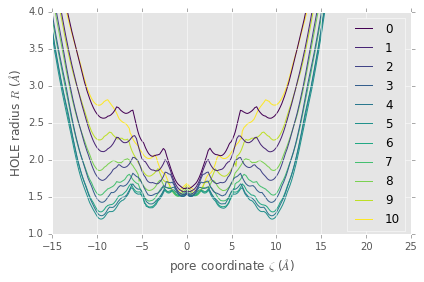

In [8]:
ax = H.plot()
ax.set_ylim(1, 4)
ax.set_xlim(-15, 25)
plt.tight_layout()

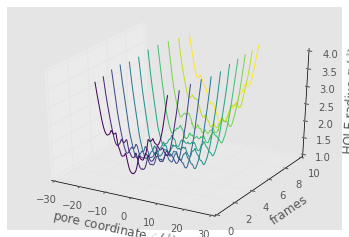

In [9]:
H.plot3D(rmax=4)

## Working with HOLE profiles
The output from HOLE is a pore profile $R(\zeta)$ (radius $R$ vs pore coordinate $\zeta$).


### Pore profile data structure
All pore profiles are stored in a `dict` named `H.profiles` that is indexed by the frame number. Each pore profile itself is a array containig rows with *frame number* (all identical), *pore coordinate*, and *pore radius*. For more details, see the docs on  [HOLE data structures](http://pythonhosted.org/MDAnalysis/documentation_pages/analysis/hole.html#data-structures).

H.profiles

### Accessing profiles on a per-frame basis
To get at individual profiles in we can iterate over `H.profiles`. However, as a convenience, just iterating over the `HOLEtraj` instance itself will return the profiles in *frame-sorted order* (thanks to [HOLEtraj.sorted_profiles_iter()](http://pythonhosted.org/MDAnalysis/documentation_pages/analysis/hole.html#MDAnalysis.analysis.hole.HOLEtraj.sorted_profiles_iter)).

For example, getting the minimum radius 

In [10]:
for frame, profile in H:
    print("frame {}: min(R) = {}".format(frame, profile.radius.min()))

frame 0: min(R) = 1.61053
frame 1: min(R) = 1.56725
frame 2: min(R) = 1.53256
frame 3: min(R) = 1.42478
frame 4: min(R) = 1.2435
frame 5: min(R) = 1.19875
frame 6: min(R) = 1.2961
frame 7: min(R) = 1.44253
frame 8: min(R) = 1.51073
frame 9: min(R) = 1.52824
frame 10: min(R) = 1.56024


(For a slightly more advanced [analysis of minimum pore radius as function of a order parameter](http://nbviewer.jupyter.org/gist/orbeckst/a0c856f58059112538591af108df6d59#Analysis-of-the-minimum-pore-radius) see the [Advanced HOLE Hacking Notebook](http://nbviewer.jupyter.org/gist/orbeckst/a0c856f58059112538591af108df6d59).)

###  Extracting data to a file
Sometimes you want to have the pore profiles in a simple data file. Here we are using the popular [XMGRACE](http://plasma-gate.weizmann.ac.il/Grace/) XY format where each row will contain
```
   pore_coordinate   pore_radius
```
and datasets for frames are separated by
```
&
```

In [11]:
with open("profiles.xvg", "w") as xvg:
    for frame, profile in H:
        for _, zeta, radius in profile:
            xvg.write("{0} {1}\n".format(zeta, radius))
        xvg.write("&\n")

The corresponding output file looks like this:

In [17]:
print("".join(open("profiles.xvg").readlines()[440:460]))

21.387 10.41399
21.487 10.46226
21.587 11.06096
21.687 12.11576
21.787 13.51356
21.887 14.94337
21.987 16.99936
&
-22.01283 21.9034
-21.91283 19.06584
-21.81283 16.65472
-21.71283 14.91447
-21.61283 13.49857
-21.51283 11.55906
-21.41283 10.27238
-21.31283 9.97615
-21.21283 9.9346
-21.11283 9.84064
-21.01283 9.74689
-20.91283 9.65261



One can use the above code to write the profiles in any format; for instance, it would be easy to write each frame's profile to a separate file by moving the `with` statement *inside* the outer `for` loop.

## Creating an "average" HOLE profile 

At the moment (MDAnalysis 0.15.0) does not have a method to compute an average HOLE profile. However, in the following I demonstrate how this can be accomplished using the [numkit.timeseries.regularized_function](http://gromacswrapper.readthedocs.io/en/latest/numkit/timeseries.html#numkit.timeseries.regularized_function) (a function found in [GromacsWrapper](http://gromacswrapper.readthedocs.io/)) but we can also use it independently (I copied it from [numkit/timeseries.py](https://github.com/Becksteinlab/GromacsWrapper/blob/develop/numkit/timeseries.py#L519)):

In [18]:
import numpy
from itertools import izip

def regularized_function(x, y, func, bins=100, range=None):
    """Compute *func()* over data aggregated in bins.
    ``(x,y) --> (x', func(Y'))``  with ``Y' = {y: y(x) where x in x' bin}``
    First the data is collected in bins x' along x and then *func* is
    applied to all data points Y' that have been collected in the bin.
    .. function:: func(y) -> float
       *func* takes exactly one argument, a numpy 1D array *y* (the
       values in a single bin of the histogram), and reduces it to one
       scalar float.
    .. Note:: *x* and *y* must be 1D arrays.
    :Arguments:
       x
          abscissa values (for binning)
       y
          ordinate values (func is applied)
       func
          a numpy ufunc that takes one argument, func(Y')
       bins
          number or array
       range
          limits (used with number of bins)
    :Returns:
       F,edges
          function and edges (``midpoints = 0.5*(edges[:-1]+edges[1:])``)
    (This function originated as
    :func:`recsql.sqlfunctions.regularized_function`.)
    """
    _x = numpy.asarray(x)
    _y = numpy.asarray(y)

    if len(_x.shape) != 1 or len(_y.shape) != 1:
        raise TypeError("Can only deal with 1D arrays.")

    # setup of bins (taken from numpy.histogram)
    if (range is not None):
        mn, mx = range
        if (mn > mx):
            raise AttributeError('max must be larger than min in range parameter.')

    if not numpy.iterable(bins):
        if range is None:
            range = (_x.min(), _x.max())
        mn, mx = [float(mi) for mi in range]
        if mn == mx:
            mn -= 0.5
            mx += 0.5
        bins = numpy.linspace(mn, mx, bins+1, endpoint=True)
    else:
        bins = numpy.asarray(bins)
        if (numpy.diff(bins) < 0).any():
            raise ValueError('bins must increase monotonically.')

    sorting_index = numpy.argsort(_x)
    sx = _x[sorting_index]
    sy = _y[sorting_index]

    # boundaries in SORTED data that demarcate bins; position in bin_index is the bin number
    bin_index = numpy.r_[sx.searchsorted(bins[:-1], 'left'),
                         sx.searchsorted(bins[-1], 'right')]

    # naive implementation: apply operator to each chunk = sy[start:stop] separately
    #
    # It's not clear to me how one could effectively block this procedure (cf
    # block = 65536 in numpy.histogram) because there does not seem to be a
    # general way to combine the chunks for different blocks, just think of
    # func=median
    F = numpy.zeros(len(bins)-1)  # final function
    F[:] = [func(sy[start:stop]) for start,stop in izip(bin_index[:-1],bin_index[1:])]
    return F,bins

The strategy is to collect all data and the histogram the radii over the HOLE reactioncoordinate:

In [19]:
rxncoord = np.concatenate([profile.rxncoord for frame, profile in H.sorted_profiles_iter()])
radii = np.concatenate([profile.radius for frame, profile in H.sorted_profiles_iter()])

Now use `regularized_function`.

Normally I would import it as
```python
from numkit.timeseries import regularized_function
```
but for this notebook it is not necessary to install GromacsWrapper (`pip install gromacswrapper`...).

The function to reduce the data in each bin is either just the mean (`np.mean`) or the standard deviation (`np.std`). (For more ideas what else to use see the numkit notes on [coarse graining timeseries](http://gromacswrapper.readthedocs.io/en/latest/numkit/timeseries.html#coarse-graining-time-series).)

In [20]:
mean_r, q = regularized_function(rxncoord, radii, np.mean, bins=100)
std_r, q = regularized_function(rxncoord, radii, np.std, bins=100)
zeta = 0.5*(q[1:] + q[:-1])

Note that `regularized_function()` returns the reduced data in each bin $i$ and the bin edges (the bin $i$ is defined as $\{q: q_i \leq q < q_{i+1}\}$). To plot over the bin midpoints, we compute them as $\zeta_i = \frac{1}{2}(q_i + q_{i+1})$.

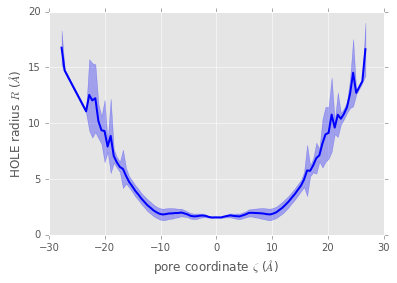

In [21]:
ax = plt.subplot(111)
ax.fill_between(zeta, mean_r - std_r, mean_r + std_r, color="blue", alpha=0.3)
ax.plot(zeta, mean_r, color="blue", lw=2)
ax.set_xlabel(r"pore coordinate $\zeta$ ($\AA$)")
ax.set_ylabel(r"HOLE radius $R$ ($\AA$)");

This is a plot of the mean pore radius (solid line) with the bands showing the standard deviation of the radius over the trajectory.

## Further reading
For more advanced uses see
* notebook: [Using MDAnalysis and HOLE to create pore profiles along structural order parameters](http://nbviewer.jupyter.org/gist/orbeckst/a0c856f58059112538591af108df6d59)